# 数据处理

## 引入第三方包

In [1]:
from PIL import Image
from keras import backend as K

import random
import glob

import numpy as np
import tensorflow.gfile as gfile
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 定义超参数和字符集

In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LOWERCASE = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']
UPPERCASE = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
           'V', 'W', 'X', 'Y', 'Z']

CAPTCHA_CHARSET = NUMBER   # 验证码字符集
CAPTCHA_LEN = 4            # 验证码长度
CAPTCHA_HEIGHT = 60        # 验证码高度
CAPTCHA_WIDTH = 160        # 验证码宽度

TRAIN_DATA_DIR = './train-data/' # 验证码数据集目录

## 读取训练集前 100 张图片，并通过文件名解析验证码（标签）

In [3]:
image = []
text = []
count = 0
for filename in glob.glob(TRAIN_DATA_DIR + '*.png'):
    image.append(np.array(Image.open(filename)))
    text.append(filename.lstrip(TRAIN_DATA_DIR).rstrip('.png'))
    count += 1
    if count >= 100:
        break

## 数据可视化

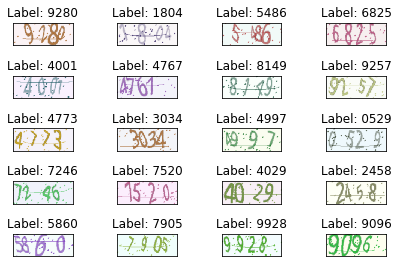

In [4]:
plt.figure()
for i in range(20):
    plt.subplot(5,4,i+1) # 绘制前20个验证码，以5行4列子图形式展示
    plt.tight_layout() # 自动适配子图尺寸
    plt.imshow(image[i])
    plt.title("Label: {}".format(text[i])) # 设置标签为子图标题
    plt.xticks([]) # 删除x轴标记
    plt.yticks([]) # 删除y轴标记
plt.show()

In [5]:
image = np.array(image, dtype=np.float32)

In [6]:
print(image.shape)

(100, 60, 160, 3)


## 将 RGB 验证码图像转为灰度图

In [7]:
def rgb2gray(img):
    # Y' = 0.299 R + 0.587 G + 0.114 B 
    # https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [8]:
image = rgb2gray(image)

In [9]:
print(image.shape)

(100, 60, 160)


In [10]:
image[0]

array([[245.62, 245.62, 245.62, ..., 245.62, 245.62, 245.62],
       [245.62, 245.62, 245.62, ..., 245.62, 245.62, 245.62],
       [245.62, 245.62, 245.62, ..., 245.62, 245.62, 245.62],
       ...,
       [245.62, 245.62, 245.62, ..., 245.62, 245.62, 245.62],
       [245.62, 245.62, 245.62, ..., 245.62, 245.62, 245.62],
       [245.62, 245.62, 245.62, ..., 245.62, 245.62, 245.62]])

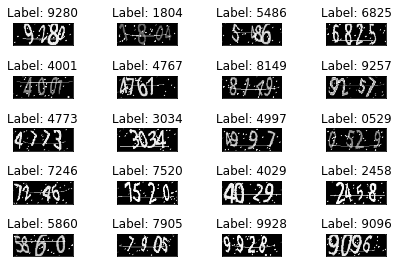

In [11]:
plt.figure()
for i in range(20):
    plt.subplot(5,4,i+1) # 绘制前20个验证码，以5行4列子图形式展示
    plt.tight_layout() # 自动适配子图尺寸
    plt.imshow(image[i], cmap='Greys')
    plt.title("Label: {}".format(text[i])) # 设置标签为子图标题
    plt.xticks([]) # 删除x轴标记
    plt.yticks([]) # 删除y轴标记
plt.show()

## 数据规范化

In [12]:
image = image / 255

In [13]:
image[0]

array([[0.96321569, 0.96321569, 0.96321569, ..., 0.96321569, 0.96321569,
        0.96321569],
       [0.96321569, 0.96321569, 0.96321569, ..., 0.96321569, 0.96321569,
        0.96321569],
       [0.96321569, 0.96321569, 0.96321569, ..., 0.96321569, 0.96321569,
        0.96321569],
       ...,
       [0.96321569, 0.96321569, 0.96321569, ..., 0.96321569, 0.96321569,
        0.96321569],
       [0.96321569, 0.96321569, 0.96321569, ..., 0.96321569, 0.96321569,
        0.96321569],
       [0.96321569, 0.96321569, 0.96321569, ..., 0.96321569, 0.96321569,
        0.96321569]])

## 适配 Keras 图像数据格式

In [14]:
def fit_keras_channels(batch, rows=CAPTCHA_HEIGHT, cols=CAPTCHA_WIDTH):
    if K.image_data_format() == 'channels_first':
        batch = batch.reshape(batch.shape[0], 1, rows, cols)
        input_shape = (1, rows, cols)
    else:
        batch = batch.reshape(batch.shape[0], rows, cols, 1)
        input_shape = (rows, cols, 1)
    
    return batch, input_shape

In [15]:
image, input_shape = fit_keras_channels(image)
print(image.shape)
print(input_shape)

(100, 60, 160, 1)
(60, 160, 1)


## 对验证码中每个字符进行 one-hot 编码

In [16]:
def text2vec(text, length=CAPTCHA_LEN, charset=CAPTCHA_CHARSET):
    text_len = len(text)
    # 验证码长度校验
    if text_len != length:
        raise ValueError('Error: length of captcha should be {}, but got {}'.format(length, text_len))
    
    # 生成一个形如（CAPTCHA_LEN*CAPTHA_CHARSET,) 的一维向量
    # 例如，4个纯数字的验证码生成形如(4*10,)的一维向量
    vec = np.zeros(length * len(charset))
    for i in range(length):
        # One-hot 编码验证码中的每个数字
        # 每个字符的热码 = 索引 + 偏移量
        vec[charset.index(text[i]) + i*len(charset)] = 1
    return vec

In [17]:
text = list(text)
vec = [None]*len(text)

In [18]:
for i in range(len(vec)):
    vec[i] = text2vec(text[i])

In [19]:
vec[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [20]:
text[0]

'9280'

## 将验证码向量解码为对应字符

In [21]:
def vec2text(vector):
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    vector = np.reshape(vector, [CAPTCHA_LEN, -1])
    text = ''
    for item in vector:
        text += CAPTCHA_CHARSET[np.argmax(item)]
    return text

In [22]:
# 模型对 ‘3935’ 验证码推理的输出值
yy_vec = np.array([[2.0792404e-10, 4.3756086e-07, 3.1140310e-10, 9.9823320e-01,
                    5.1135743e-15, 3.7417038e-05, 1.0556480e-08, 9.0933657e-13,
                    2.7573466e-07, 1.7286760e-03, 1.1030550e-07, 1.1852034e-07,
                    7.9457263e-10, 3.4533365e-09, 6.6065012e-14, 2.8996323e-05,
                    7.6345885e-13, 3.1817032e-16, 3.9540555e-05, 9.9993122e-01,
                    5.3814397e-13, 1.2061575e-10, 1.6408040e-03, 9.9833637e-01,
                    6.5149628e-08, 5.2246549e-12, 1.1365444e-08, 9.5700288e-12,
                    2.2725430e-05, 5.2195204e-10, 3.2457771e-13, 2.1413280e-07,
                    7.3547295e-14, 4.4094882e-06, 3.8390007e-07, 9.9230206e-01,
                    6.4467136e-03, 3.9224533e-11, 1.2461344e-03, 1.1253484e-07]],
                  dtype=np.float32)

In [23]:
yy = vec2text(yy_vec)

In [24]:
img = rgb2gray(np.array(Image.open('3935.png')))

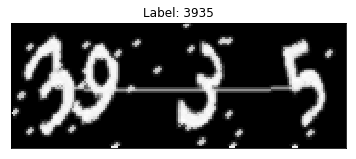

In [25]:
plt.figure()
plt.imshow(img, cmap='Greys')
plt.title("Label: {}".format(yy)) # 设置标签为图标题
plt.xticks([]) # 删除x轴标记
plt.yticks([]) # 删除y轴标记
plt.show()